In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# 중력 상수 (G)와 질량 설정
G = 1.0
m1 = 1.0; m2 = 1.0; m3 = 1.0

In [3]:
# --- 1. 미분 방정식 정의 ---
def three_body_equations(w, t, G, m1, m2, m3):
    
    # 위치 및 속도 벡터 분리
    r1 = w[0:3]; r2 = w[3:6]; r3 = w[6:9]
    v1 = w[9:12]; v2 = w[12:15]; v3 = w[15:18]
    
    # 거리 계산
    r12 = np.linalg.norm(r2 - r1)
    r13 = np.linalg.norm(r3 - r1)
    r23 = np.linalg.norm(r3 - r2)
    
    # 가속도 계산 (dv/dt)
    dv1dt = (G * m2 * (r2 - r1) / r12**3) + (G * m3 * (r3 - r1) / r13**3)
    dv2dt = (G * m1 * (r1 - r2) / r12**3) + (G * m3 * (r3 - r2) / r23**3)
    dv3dt = (G * m1 * (r1 - r3) / r13**3) + (G * m2 * (r2 - r3) / r23**3)
    
    # dw/dt = [v, a] 반환
    return np.concatenate((v1, v2, v3, dv1dt, dv2dt, dv3dt))

In [4]:
# --- 2. RK4 알고리즘 함수 정의 ---
def runge_kutta_4(func, w_n, t_n, dt, G, m1, m2, m3):
   
    
    # k1: 시작점의 기울기
    k1 = func(w_n, t_n, G, m1, m2, m3)
    
    # k2: 중간점 1의 기울기
    k2 = func(w_n + dt * k1 / 2, t_n + dt / 2, G, m1, m2, m3)
    
    # k3: 중간점 2의 기울기
    k3 = func(w_n + dt * k2 / 2, t_n + dt / 2, G, m1, m2, m3)
    
    # k4: 끝점의 기울기
    k4 = func(w_n + dt * k3, t_n + dt, G, m1, m2, m3)
    
    # 다음 시간 단계의 상태 벡터 계산
    w_n_plus_1 = w_n + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)
    
    return w_n_plus_1

In [5]:
# --- 3. 초기 조건 설정 (Figure-8) ---
x0 = 0.97000436; y0 = -0.24308753
vx0 = 0.466203685; vy0 = 0.43236573
r1_0 = [x0, y0, 0]; r2_0 = [-x0, -y0, 0]; r3_0 = [0, 0, 0]
v1_0 = [vx0, vy0, 0]; v2_0 = [vx0, vy0, 0]; v3_0 = [-2*vx0, -2*vy0, 0]

state_initial_figure8 = np.array(r1_0 + r2_0 + r3_0 + v1_0 + v2_0 + v3_0)

In [6]:
# --- 4. 시뮬레이션 설정 및 루프 실행 ---
time_span = 500.0   
num_points = 20000 
t_array = np.linspace(0, time_span, num_points)
dt = t_array[1] - t_array[0] # 고정 시간 스텝 계산

# 결과 저장 배열 초기화
solution_figure8 = np.empty((num_points, len(state_initial_figure8)))
solution_chaos = np.empty((num_points, len(state_initial_figure8)))

# 카오스 초기 조건 설정 (epsilon = 1e-3 사용)
epsilon = 1e-3
state_initial_chaos = np.copy(state_initial_figure8)
state_initial_chaos[0] += epsilon

# 현재 상태 변수 초기화
current_state_f8 = np.copy(state_initial_figure8)
current_state_chaos = np.copy(state_initial_chaos)

# --- RK4 메인 루프 ---
for i in range(num_points):
    # 현재 상태 저장
    solution_figure8[i] = current_state_f8
    solution_chaos[i] = current_state_chaos
    
    # RK4 다음 스텝 계산
    if i < num_points - 1:
        t_n = t_array[i]
        
        # 안정 궤도 스텝
        current_state_f8 = runge_kutta_4(
            three_body_equations, current_state_f8, t_n, dt, G, m1, m2, m3
        )
        # 카오스 궤도 스텝
        current_state_chaos = runge_kutta_4(
            three_body_equations, current_state_chaos, t_n, dt, G, m1, m2, m3
        )

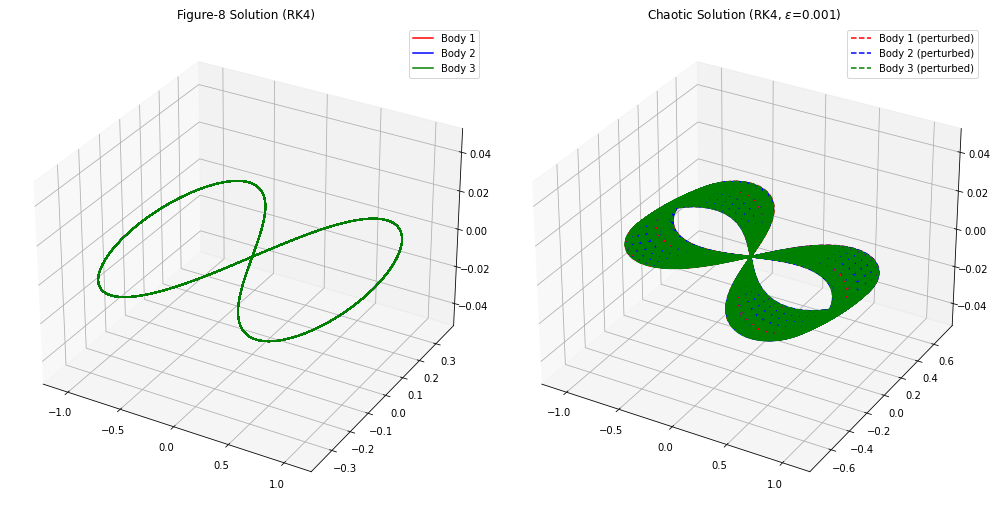

In [7]:
# --- 5. 시각화 ---
fig = plt.figure(figsize=(14, 7))

# Figure-8 궤도 플롯
ax1 = fig.add_subplot(121, projection='3d')
r1_sol_f8 = solution_figure8[:, 0:3]
r2_sol_f8 = solution_figure8[:, 3:6]
r3_sol_f8 = solution_figure8[:, 6:9]

ax1.plot(r1_sol_f8[:, 0], r1_sol_f8[:, 1], r1_sol_f8[:, 2], label='Body 1', color='red')
ax1.plot(r2_sol_f8[:, 0], r2_sol_f8[:, 1], r2_sol_f8[:, 2], label='Body 2', color='blue')
ax1.plot(r3_sol_f8[:, 0], r3_sol_f8[:, 1], r3_sol_f8[:, 2], label='Body 3', color='green')
ax1.set_title('Figure-8 Solution (RK4)')
ax1.legend()
ax1.grid(True)

# 카오스 궤도 플롯
ax2 = fig.add_subplot(122, projection='3d')
r1_sol_c = solution_chaos[:, 0:3]
r2_sol_c = solution_chaos[:, 3:6]
r3_sol_c = solution_chaos[:, 6:9]

ax2.plot(r1_sol_c[:, 0], r1_sol_c[:, 1], r1_sol_c[:, 2], label='Body 1 (perturbed)', color='red', linestyle='--')
ax2.plot(r2_sol_c[:, 0], r2_sol_c[:, 1], r2_sol_c[:, 2], label='Body 2 (perturbed)', color='blue', linestyle='--')
ax2.plot(r3_sol_c[:, 0], r3_sol_c[:, 1], r3_sol_c[:, 2], label='Body 3 (perturbed)', color='green', linestyle='--')
ax2.set_title(f'Chaotic Solution (RK4, $\\epsilon$={epsilon})')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()